<details>
   <summary>Metadata</summary> 
    title: "E-TRAINEE Exercise for 3D point cloud change analysis"<br />
    description: "This is an exercise in the third theme within the 3D/4D Geographic Point Cloud Time Series Analysis module."
    dateCreated: 2022-08<br />
    authors: Mark Searle<br />
    contributors: Katharina Anders, Bernhard Höfle <br />
    estimatedTime: 1.5 hrs
</details>

# Exercise: 3D Change Analysis at an Active Rock Glacier using Multitemporal Point Clouds

In this exercise, you will perform a surface change analysis on TLS point clouds of the Äußeres Hochebenkar rock glacier (46°50’11''N, 11°00’20‘’E) for two consecutive years. See the introduction to the case study and dataset [here](../../../data_usecases/usecase_rockglacier_ahk.md).

The objective is to perform a full workflow of 3D change analysis with

* Assessment of alignment uncertainty
* Change analysis using the M3C2 algorithm 
* Change representation and assessment of results
* For the fast ones: Comparison to change analysis via DEM differencing

Look into the article by [Zahs et al., 2019](https://doi.org/10.1002/ppp.2004) for comparison of possible surface dynamics at the site and help for deciding on suitable parameters, etc.

## Software and data
This exercise can be solved fully in [CloudCompare](../../../software/software_cloudcompare.md) or using Python with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library. If you have the Python skills, we recommend to work on the exercise with Python in a Jupyter notebook, hence obtaining a sharable and reproducible workflow.

Use CloudCompare and GIS Software (e.g., [QGIS](../../../software/software_qgis.md)) to check and visualize your results.

In any case, make use of the software documentations!

The dataset will be two epochs of point clouds acquired by UAV laser scanning in 2020 and 2021: `ahk/ahk_2020_uls.laz` and `ahk/ahk_2021_uls.laz`.

## Solution

<span style="color:blue">This solution uses Python with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library.</span> 

In [1]:
# import required modules
import os
import numpy as np
import py4dgeo

# add the script assets folder to the path, so that we can import the functions created there
import sys
from pathlib import Path
sys.path.insert(0, str((Path.cwd() / ".." / ".." / ".." / "assets" / "python_functions").resolve()))

# import point cloud functions
import pointcloud_functions as pcfuncs

<span style="color:blue">Specify the path to the data and names of input files, and read in the point cloud data:</span> 

In [2]:
# specify the path to the data directory
data_dir ='path-to-data' # /ahk
if not os.path.isdir(data_dir):
    print(f'Directory with data not found: {data_dir}')
    print('Please check the specified path')

In [3]:
# derive the file paths and read in the data
pc_file_2020 = f'{data_dir}/ahk_2020_uls.laz'
pc_file_2021 = f'{data_dir}/ahk_2021_uls.laz'

# read the point clouds into numpy arrays
pc_2020 = pcfuncs.read_las(pc_file_2020)
pc_2021 = pcfuncs.read_las(pc_file_2021)

## Assessment of alignment uncertainty
The epochs are georeferenced, i.e., multitemporal point clouds are registered in a common coordinate reference frame. The point clouds have further been fine aligned using an ICP method on stable parts outside the rock glacier area. You may assume that the best possible alignment between the multitemporal data has been achieved.

For change analysis, it is important to assess the uncertainty of the point cloud alignment for information on the minimum detectable change. Do this, by cutting out some stable rock surfaces outside the rock glacier and checking the cloud-to-cloud distances for these subsets. You may cut out point cloud subsets manually in CloudCompare, or define polygons (e.g., in QGIS) to extract the parts from the full point cloud in the Python workflow.

<span style="color:blue">We check the alignment uncertainty by cutting out some stable rock surfaces outside the rock glacier. In this solution, we have derived polygons of stable parts for one point cloud epoch (`ahk_2021_uls_stableparts.shp`). Using this, we can extract the points within stable parts (2D query) and subsequently derive the point cloud distances between epochs.</span> 

In [4]:
# specify input shapefile
shp_file = f'{data_dir}/ahk_2021_uls_stableparts.shp'

# import modules for vector/shapefile processing
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon

# read the shapefile 
datasource = gpd.read_file(shp_file)
polygons = gpd.GeoSeries(datasource['geometry'])

# to speed up the polygon selection, we make a coarse subsetting based on the XY bounding box of the polygons
miny = polygons.bounds['miny'].values[0]
maxy = polygons.bounds['maxy'].values[0]
minx = polygons.bounds['minx'].values[0]
maxx = polygons.bounds['maxx'].values[0]
pc_2020_subs = pc_2020[(pc_2020[:,1]>=miny) & (pc_2020[:,1]<=maxy) & (pc_2020[:,0]>=minx) & (pc_2020[:,0]<=maxx)]
pc_2021_subs = pc_2021[(pc_2021[:,1]>=miny) & (pc_2021[:,1]<=maxy) & (pc_2021[:,0]>=minx) & (pc_2021[:,0]<=maxx)]

print(f'Remaining points: {pc_2020_subs.shape[0]}/{pc_2020.shape[0]} for 2020; {pc_2021_subs.shape[0]}/{pc_2021.shape[0]} for 2021')

Remaining points: 8497831/37426631 for 2020; 10759711/45662285 for 2021


<span style="color:blue">In the next part, we check each remaining point for its position in the polygon/stable area. You may take a coffee break while it is running!</span> 

In [5]:
# create boolean array to mask points (initialize all entries as False)
pc_mask_2020 = np.full(len(pc_2020_subs), fill_value=False, dtype=bool)
pc_mask_2021 = np.full(len(pc_2021_subs), fill_value=False, dtype=bool)

print('Mask stable parts via polygons for 2020 points...')
# loop over xy coordinates of all points
for pt_id, (x,y) in enumerate(pc_2020_subs[:,:2]):
    point=Point([x,y])
    
    # check distance of this point to all polygons
    for poly in polygons:
        distance= poly.distance(point)
        # set mask to True, if point is within polygon
        if distance <= 0.0:
            pc_mask_2020[pt_id] = True 
            break # stop polygon checks as soon as point lies within one of them
            
pc_stable_2020 = pc_2020_subs[pc_mask_2020]

print('Mask stable parts via polygons for 2021 points...')
# loop over xy coordinates of all points
for pt_id, (x,y) in enumerate(pc_2021_subs[:,:2]):
    point=Point([x,y])
    
    # check distance of this point to all polygons
    for poly in polygons:
        distance= poly.distance(point)
        # set mask to True, if point is within polygon
        if distance <= 0.0:
            pc_mask_2021[pt_id] = True
            break # stop polygon checks as soon as point lies within one of them
            
pc_stable_2021 = pc_2021_subs[pc_mask_2021]

print(f'Remaining points: {pc_stable_2020.shape[0]}/{pc_2020.shape[0]} for 2020; {pc_stable_2021.shape[0]}/{pc_2021.shape[0]} for 2021')


Mask stable parts via polygons for 2020 points...
Mask stable parts via polygons for 2021 points...
Remaining points: 330254/37426631 for 2020; 409231/45662285 for 2021


<span style="color:blue">Create a kd tree and compute the distances:</span> 

In [6]:
# import module to build kdtree
from scipy.spatial import KDTree

# create a 2D kd-tree from the point cloud
tree2021 = KDTree(pc_stable_2021[:,:3])

# query indices of nearest neighbors of 2009 coordinates in 2017 kd-tree
nn_dists = tree2021.query(pc_stable_2020[:,:3], k=1)

# obtain distances as first element in tuple returned by query above
distances = nn_dists[0]

<span style="color:blue">We assess the distances visually, and derive the statistics:</span> 

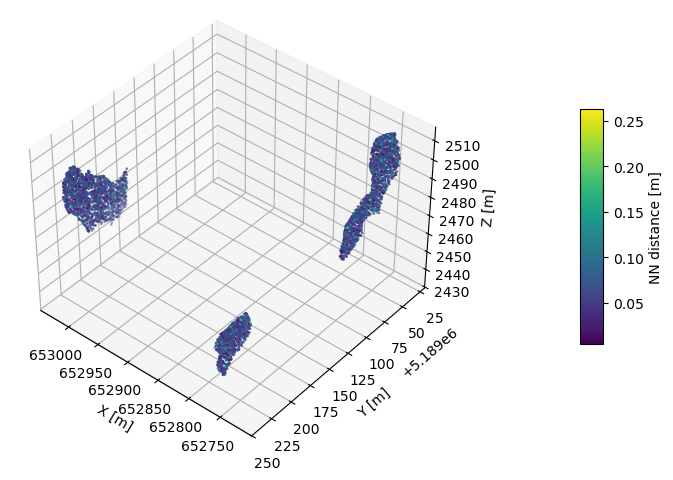

In [7]:
# import plotting module
import matplotlib.pyplot as plt

# allow interactive rotation in notebook
%matplotlib inline

# create a figure with 3D axis
fig, ax = plt.subplots(1,1,subplot_kw={"projection": "3d"},figsize=(7,5))

nth=100

# plot the point cloud colored by height (z values)
s = ax.scatter(pc_stable_2020[::nth,0], pc_stable_2020[::nth,1], pc_stable_2020[::nth,2], s=1, c=distances[::nth])

# label axes and add title
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# set initial view of 3D plot
ax.view_init(elev=40., azim=130.)

# add a colorbar
fig.colorbar(s, shrink=.5, aspect=10, label='NN distance [m]', ax = ax, pad=0.2)

# show the plot
plt.tight_layout()
plt.show()

In [8]:
# print statistics of nn distances
print(f'Median distances: {np.median(distances):.3f} m')
print(f'Std. dev. of distances: {np.std(distances):.3f} m')

Median distances: 0.060 m
Std. dev. of distances: 0.151 m


<span style="color:blue">The distances are quite large according to the statistics. We would assume lower values for the (visual) quality of the co-registration and the measurement accuracy of UAV laser scanning in this scene. An explanation for the large values could be the influence of point sampling, so you see here an effect of the drawbacks in simple cloud-to-cloud (C2C) distance computation. For a potentially more robust result, we derive the M3C2 distances in these stable parts (for a detailed solution how to establish the M3C2 change analysis, see the remainder of the solution).</span>

In [9]:
# load the stable parts as py4dgeo Epochs
epoch2020_stable = py4dgeo.epoch.as_epoch(pc_stable_2020)
epoch2021_stable = py4dgeo.epoch.as_epoch(pc_stable_2021)

# instantiate the M3C2 algorithm object, using all points of 2020 as corepoints (no subsampling)
m3c2 = py4dgeo.M3C2(
    epochs=(epoch2020_stable, epoch2021_stable),
    corepoints=epoch2020_stable.cloud[::],
    normal_radii=(0.5,),
    cyl_radii=(0.5,),
    max_distance=(5.0),
    registration_error=(0.0)
)

# run the distance computation
m3c2_distances_stableparts, uncertainties_stableparts = m3c2.run()

# print statistics of nn distances
print(f'Median M3C2 distances: {np.nanmedian(m3c2_distances_stableparts):.3f} m')
print(f'Std. dev. of M3C2 distances: {np.nanstd(m3c2_distances_stableparts):.3f} m')

[2025-02-11 17:50:52][INFO] Initializing Epoch object from given point cloud
[2025-02-11 17:50:52][INFO] Initializing Epoch object from given point cloud
[2025-02-11 17:50:52][INFO] Building KDTree structure with leaf parameter 10
[2025-02-11 17:50:52][INFO] Building KDTree structure with leaf parameter 10
Median M3C2 distances: -0.013 m
Std. dev. of M3C2 distances: 0.037 m


<span style="color:blue">As the M3C2 distances provide a more robust etimate of point distances in the stable parts, we use their standard deviation as measure of alignment accuracy in our change analysis. This measure we can later on use as registration error for deriving the level of detection.</span>

In [10]:
reg_2020_2021 = np.nanstd(m3c2_distances_stableparts)
print(f'Registration error based on point distances in stable parts is {reg_2020_2021:.3f} m.')

Registration error based on point distances in stable parts is 0.037 m.


<span style="color:blue">This value already provides as an estimate of change magnitudes which can be confidently derived from point cloud comparison of these two epochs. In the M3C2 distance calculation, we will derive the per-point level of detection considering the local (i.e. spatially variable) roughness and point density.</span>

<span style="color:blue">By the way, we can free up some working memory by removing the point cloud arrays here. In the following, we continue with `py4dgeo` and therefore load the data into (new) `Epoch`objects.</span>

In [11]:
pc_2020 = None
pc_2021 = None
pc_2020_subs = None
pc_2021_subs = None
pc_stable_2020 = None
pc_stable_2021 = None

## 3D change analysis via point cloud distance computation

Calculate the distance between point clouds of the two epochs using the M3C2 algorithm ([Lague et al., 2013](https://doi.org/10.1016/j.isprsjprs.2013.04.009)). 

Think about a suitable parametrization:
* Normal scale D: diameter of point neighborhood to use for normal vector computation. *Hint*: Aim for overall, larger-scale surface change, e.g. due to rock glacier creep or heave/thaw (instead of individual boulders).
* Projection scale d: diameter of cylindrical point neighborhood to obtain average position.
* Maximum cylinder depth: Maximum distance along normal at which to obtain distances to the other point cloud.
* Preferred normal orientation.
* Registration error ~ alignment accuracy

Consider using the [py4dgeo documentation](https://py4dgeo.readthedocs.io/en/latest/intro.html).

<span style="color:blue">To perform the M3C2 change analyis with py4dgeo, we need to read the data into `Epoch` objects. This can be done from the `Nx3` array of coordinates using the function `py4dgeo.epoch.as_epoch()`, or directly from file using `py4dgeo.read_from_las()`.</span>

In [12]:
# load epochs into py4dgeo objects
epoch2020 = py4dgeo.read_from_las(pc_file_2020)
epoch2021 = py4dgeo.read_from_las(pc_file_2021)

[2025-02-11 17:50:53][INFO] Reading point cloud from file 'D:/Software/etrainee/module3/ahk/ahk_2020_uls.laz'
[2025-02-11 17:50:55][INFO] Reading point cloud from file 'D:/Software/etrainee/module3/ahk/ahk_2021_uls.laz'


<span style="color:blue">As core points, we use a subsampling of coordinates in the epoch of 2020 (which will be the reference for deriving M3C2 distances to the later epoch of 2021), e.g. using every 100th point.</span>

In [13]:
# use every nth point as core point for distance calculation
corepoints = epoch2020.cloud[::100]

<span style="color:blue">We parametrize the M3C2 algorithm object according to the parameters in [Zahs et al., 2019](#references), and use the registration error we derived above. The default normal orientation in `py4dgeo` is upwards (``), so we do not need to adapt/set this parameter.</span>

In [14]:
# instantiate and parametrize the M3C2 algorithm object
m3c2 = py4dgeo.M3C2(
    epochs=(epoch2020, epoch2021),
    corepoints=corepoints,
    normal_radii=(4.0, 0.5, 6.0),
    cyl_radii=(0.5,),
    max_distance=(15.0),
    registration_error=(reg_2020_2021)
)

<span style="color:blue">Now the analysis can be run - and another small break would be suitable for the waiting time ;-)</span>

In [15]:
m3c2_distances, uncertainties = m3c2.run()

[2025-02-11 17:50:57][INFO] Building KDTree structure with leaf parameter 10
[2025-02-11 17:51:10][INFO] Building KDTree structure with leaf parameter 10


<span style="color:blue">All change information (distances and uncertainties) are now contained in the returned objects.</span>

## Change representation and assessment of results

Visualize the obtained point cloud distances and corresponding information layers, such as the level of detection and the normal vectors representing the direction of changes.

Prepare the result assessment for interpretation by analysts. For example, you may rasterize the different layers and create a map, e.g., of the derived surface changes in GIS software. Tip: Use the Web Map Service (WMS) of Tyrol as a basemap: [https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer](https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer).


What are the different properties of visible changes and to which types of surface activity would you attribute them? Think of heave and subsidence processes, individual boulder movement, and rock glacier creep (cf. [Zahs et al., 2019](#references)).

<span style="color:blue">Using the level of detection computed by the M3C2, we derive for each point if the quantified change is significant:</span>

In [16]:
# create a binary mask of significant change
change_sign = np.where(abs(m3c2_distances) > uncertainties['lodetection'], True, False)

<span style="color:blue">Now we create a composite figure of the change values (distances), change directions (vertical component), level of detection and significant change:</span>

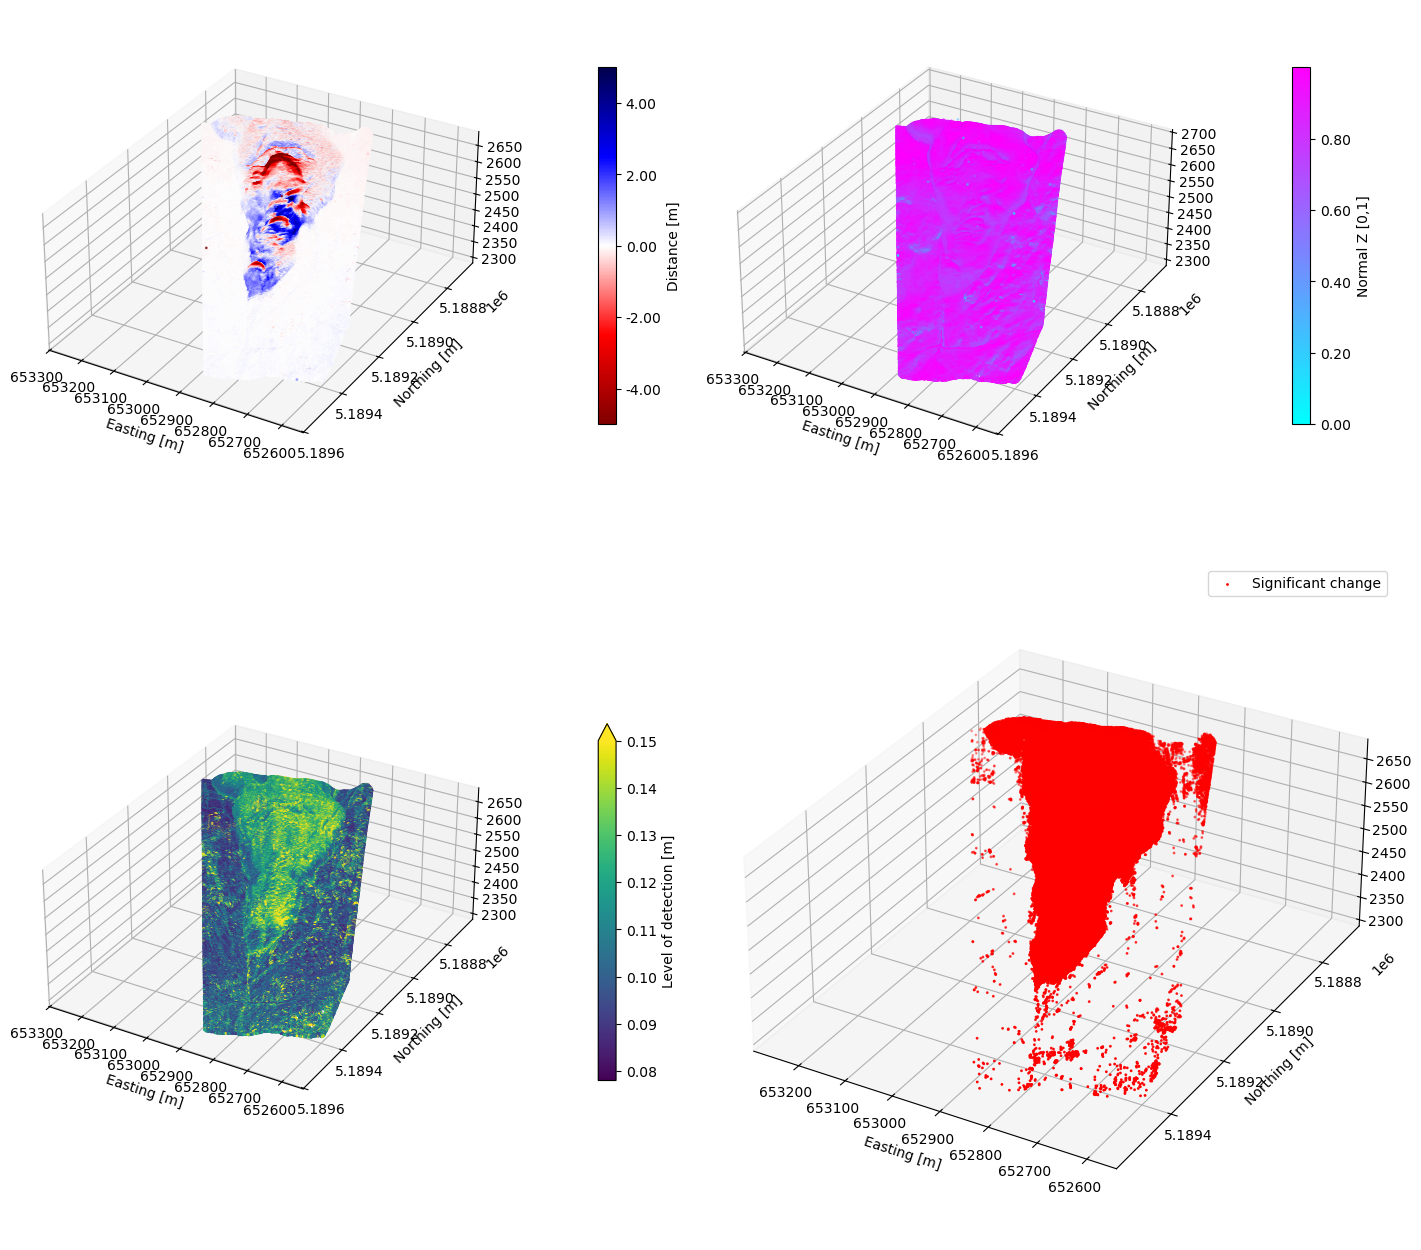

In [17]:
# create the figure
fig, axs = plt.subplots(2, 2, figsize=(14,14), subplot_kw={"projection": "3d"})
(ax1,ax2),(ax3,ax4) = axs

# plot the distances
d = ax1.scatter(corepoints[:,0], corepoints[:,1], corepoints[:,2], c=m3c2_distances, cmap='seismic_r', vmin=-5.0, vmax=5.0, s=1) 
plt.colorbar(d, format=('%.2f'), label='Distance [m]', ax=ax1, shrink=.5, pad=.15)

# plot the directions
directions = m3c2.directions()
dz = ax2.scatter(corepoints[:,0], corepoints[:,1], corepoints[:,2], c=directions[:,2], cmap='cool', s=1) 
plt.colorbar(dz, format=('%.2f'), label='Normal Z [0,1]', ax=ax2, shrink=.5, pad=.15)

# plot the level of detection values
l = ax3.scatter(corepoints[:,0], corepoints[:,1], corepoints[:,2], c=uncertainties['lodetection'], cmap='viridis', vmax=0.15, s=1) 
plt.colorbar(l, format=('%.2f'), label='Level of detection [m]', ax=ax3, extend='max', shrink=.5, pad=.15)

# plot the significant change values (boolean)
# ax4.scatter(corepoints[~change_sign][:,0], corepoints[~change_sign][:,1], corepoints[~change_sign][:,2], label='Not significant change', c='blue', s=1) # if added, visibility of significant change areas is poor
ax4.scatter(corepoints[change_sign][:,0], corepoints[change_sign][:,1], corepoints[change_sign][:,2], label='Significant change', c='red', s=1) 
ax4.legend()

# add plot elements
for ax_set in axs:
    for ax in ax_set:
        ax.set_xlabel('Easting [m]')
        ax.set_ylabel('Northing [m]')
        ax.set_aspect('equal')
        ax.view_init(elev=30., azim=120.)

plt.axis('equal')
plt.tight_layout()
plt.show()

<span style="color:blue">For further analysis and visualization in external software, we store the result in one point cloud as laz file, adding all the attributes of the change analysis result:</span>

In [18]:
# define path for the las file
pc_m3c2 = f'{data_dir}/ahk_2020_2021_m3c2.laz'

# create a dictionary of attributes to store with the point cloud
attr = {'m3c2_distance':m3c2_distances,
        'level_of_detection':uncertainties['lodetection'],
        'significant_change':change_sign.astype(int),
        'NormalX':directions[:,0], 'NormalY':directions[:,1], 'NormalZ':directions[:,2]
        }

# use las write function to write file
pcfuncs.write_las(corepoints, pc_m3c2, attribute_dict=attr)


<span style="color:blue">To create raster layers for further analysis and visualization in a GIS, we use [PDAL](https://pdal.io/en/latest/stages/writers.gdal.html) (cf. [Theme 2](../../02_pointcloud_programming_python/02_pointcloud_programming_python.ipynb))</span>

In [19]:
import pdal

# replacing backslashes by forward slashes is required for some Windows paths
pc_m3c2 = pc_m3c2.replace("\\", "/")

# define the raster file names based on the input file name
raster_distance = pc_m3c2.replace(".laz", "_distances.tif")
raster_lodet = pc_m3c2.replace(".laz", "_lodetection.tif")

# define the pdal pipeline as json, "dimension" allows us to define the attribute to be rasterized (default: "Z" value / elevation)
json_rast = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "dimension":"%s",
        "window_size":8
    }
]"""

# execute the pipeline for the distance raster
json_dist = json_rast % (pc_m3c2, raster_distance, "m3c2_distance")
pipeline = pdal.Pipeline(json_dist)
exe = pipeline.execute()

# execute the pipeline for the lodetection raster
json_lodet = json_rast % (pc_m3c2, raster_lodet, "level_of_detection")
pipeline = pdal.Pipeline(json_lodet)
exe = pipeline.execute()

<span style="color:blue">You can now create useful raster-based map visualizations as well, e.g. in QGIS. In the corresponding [solution video](m3_theme3_exercise1_solution2.md) you can see how this is done.</span>


<img src="media/LoD_M3C2.png" alt="Visualization of LoD and M3C2" title="Visualization of LoD and M3C2" width="700">
<center>
<i>Raster-based map visualizations with Tyrol basemap: Level of detection (left) and M3C2 distances (right)(https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer). </i></center>


## For the fast ones: Change analysis via DEM differencing

Generate a DEM from the point cloud of each epoch and subsequently difference them. Think about a suitable parametrization, particularly the interpolation method and neighborhood definition. Visualize the raster of change information in GIS software. Check the [solution video](m3_theme3_exercise1_solution2.md) for further assistance.

Compare the DEM of difference values to the M3C2 distances and their directions. 
* Where do the derived changes differ mostly due to the vertical vs. 3D approach to change analysis?
* How does the analysis hence benefit from a full 3D method of change quantification?

In [20]:
import pdal

# define the point cloud paths for both epochs
pc_file_2020 = f'{data_dir}/ahk_2020_uls.laz'
pc_file_2021 = f'{data_dir}/ahk_2021_uls.laz'

# replacing backslashes by forward slashes is required for some Windows paths
pc_file_2020 = pc_file_2020.replace("\\", "/")
pc_file_2021 = pc_file_2021.replace("\\", "/")


# define the DEM raster file name based on the input file name
DEM_2020 = pc_file_2020.replace(".laz", "_DEM.tif")
DEM_2021 = pc_file_2021.replace(".laz", "_DEM.tif")

<span style="color:blue">We start calculating the DEM from the 2020 pointcloud with the following pipeline:</span>

In [21]:
json_DEM = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8
    }
]"""% (pc_file_2020, DEM_2020)  

In [22]:
pipeline = pdal.Pipeline(json_DEM)
exe = pipeline.execute()

<span style="color:blue">Next we calculate the dimensions of the 2020 DEM raster, so the 2021 DEM raster can be adapted accordingly.</span>

In [23]:
import rasterio as rio

with rio.open(DEM_2020) as src:
    DEM_2020_data = src.read(1, masked=True)
    width = src.width
    height = src.height
    
with rio.open(DEM_2020) as src:
    DEM_2020_data = src.read(1, masked=True)
    DEM_2020_tf = src.transform
    DEM_2020_bounds = src.bounds
    DEM_meta = src.profile
    width= src.width
    height = src.height
    
origin_left, origin_bottom, origin_right, origin_top = DEM_2020_bounds
DEM_width = DEM_meta['width']
DEM_height = DEM_meta['height']
    

<span style="color:blue">Next we create the DEM from the 2021 pointcloud, with the dimension parameters we just calculated.</span>

In [24]:
json_DEM = """[
    "%s",
    {
        "type":"writers.gdal",
        "filename": "%s",
        "output_type":"min",
        "gdaldriver":"GTiff",
        "resolution":1.0,
        "window_size":8,
        "origin_x":"%.3f",
        "origin_y":"%.3f",
        "width":"%i",
        "height":"%i"
    }
]"""% (pc_file_2021, DEM_2021, origin_left, origin_bottom, DEM_width, DEM_height)

In [25]:
pipeline = pdal.Pipeline(json_DEM)
exe = pipeline.execute()

In [26]:
with rio.open(DEM_2021) as src:
    DEM_2021_data = src.read(1, masked=True)

<span style="color:blue">Now we can calculate the DEM of difference (This can be done in QGIS as well):</span>

In [27]:
DEM_diff = DEM_2021_data - DEM_2020_data

<span style="color:blue">Save the created DEM of difference to a file so you can have a look at it in QGIS.</span>

In [29]:
output_path = Path(data_dir) / 'DEM_diff.tif'

with rio.open(output_path, 'w', **DEM_meta) as ff:
    ff.write(DEM_diff, 1)

<span style="color:blue">The visualized raster should look something like this:</span>

<img src="media/DEM_diff.png" alt="Visualization of vertical change" title="Visualization of vertical change" width="500">
<center>
<i>Change analysis via DEM differencing: Vertical change between 2020 and 2021. The basemap is provided by the Web Map Service of Tyrol (https://gis.tirol.gv.at/arcgis/services/Service_Public/orthofoto/MapServer/WMSServer). </i></center>




## References

* Lague, D., Brodu, N., & Leroux, J. (2013). Accurate 3D comparison of complex topography with terrestrial laser scanner: Application to the Rangitikei canyon (N-Z). ISPRS Journal of Photogrammetry and Remote Sensing, 82, pp. 10-26. doi: [10.1016/j.isprsjprs.2013.04.009](https://doi.org/10.1016/j.isprsjprs.2013.04.009).

* Zahs, V., Hämmerle, M., Anders, K., Hecht, S., Sailer, R., Rutzinger, M., Williams, J. G., & Höfle, B. (2019). Multi-temporal 3D point cloud-based quantification and analysis of geomorphological activity at an alpine rock glacier using airborne and terrestrial LiDAR. Permafrost and Periglacial Processes, 30 (3), pp. 222-238. doi: [10.1002/ppp.2004](https://doi.org/10.1002/ppp.2004).